# **Spatial Estimation of Chronic Respiratory Disease Based on Geospatial Learning Procedures - An Approach Using Earth-Engine-Based Remote Sensing Data and Air Quality Variables in the State of Pennsylvania**

**Emily Zhou, Shuai Wang**

*Department of City and Regional Planning, Weitzman School of Design, University of Pennsylvania*

Version 1.0 | First Created Apr 1, 2024 | Updated Apr 18, 2024

Keywords: support vector machine, random forest, multiple layer perceptron, deep learning, bayesian information criteria, google earth engine, geospatial health

Important Links: [original paper](https://doi.org/10.1016/j.apgeog.2020.102273), [project repository](https://github.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/tree/main)



## **1. Introduction**

In the past few years, remote sensing data have increasingly been used in monitoring, spatial predicting modeling, and risk assessment with respect to human health for their ability to facilitate the identification of social and environment determinants of health and to provide consistent spatial and temporal coverage of study data. In the meantime, machine learning techniques have been widely used in public health research to enhance the accuracy of disease prediction and early detection, improve the efficiency of healthcare resource allocation, and enable the development of personalized treatment plans.

As an example of applying remote sensing data and machine learning techniques in health research, Alvarez-Mendoza et al. conducted a study in 2020, in which they proposed to estimate the prevalence of Chronic Respiratory Diseases (CRDs) by examining the relationship between remote sensing data, air quality variables, and the number of hospital discharges of patients with CRDs in Quito, Ecuador. Specifically, their study estimated and compared three different complex machine learning techniques, support vector regression, random forest regression, and multiple layer perceptron, in predicting CRD rate, considering the effect of environmental variables, air pollution field measurements, and meteorological data. Their goal is to provide insights into and an understanding of the most significant spatial predictors and the spatial distribution of HCRD in the city of Quito.

In our final project, we plan to replicate and improve upon Alvarez-Mendoza et al.’s study and investigate the effectiveness of several machine learning models in predicting the number of hospital discharge patients with CRD in the state of Pennsylvania. Following their established workflow, we combined multiple data sources, including specific bands of satellite imageries, different kinds of vegetation indices, monthly air pollutant measures, and meterological indicators, as proxies for local environment to analyze the distribution of CRD hospitalizations across the Pennsylvania. **Our goal is to understand the most significant environmental and atmospheric factors leading to higher CRD risk in Pennsylvania as well as to compare the performance of different machine learning models.**

Our biggest deviation from Alvarez-Mendoza et al.’s study is to conduct the analysis at a much larger geographic extent. Since our raw data all comes from different sources and with different geographic unit (eg. hospital discharge data are colelcted a county level while remote sensing data are at 30\*30m spatial resolution), we divide Pennsylvania into 8397 5000\*5000m contiguous fishnet grids. Doing so provide a regular and systematic way to divide geographic areas into smaller units. It simplifies our analysis by providing a structured framework for organizing and processing spatial data. Another major deviation from the original study is the availability of air quality data in Pennsylvania. Because the influence of air quality monitoring stations is not limited by administrative boudaries, making spatial interpolation of their influence zone becomes an important step before analysis. We computed several voronoi polygons based on station locations that collect different kinds of air quality data. Each station is associated with a polygon representing the area where it has the closet proximity, from which we could then aggregate to the fishnet. The third deviation is that we took seasonality into account while running the machine learning model. Specifically, models were ran on data from different seasons separately for cross-comparison.

This notebook documents our entire replication study and is organized into the following sections following the workflow of Alvarez-Mendoza et al.:
- Study Area: where we document the procedure of generating the fishnet and defining our area of interest.   
- Remote Sensing Data: where we document our process of retreving, fine-tuning, and manipulating satellite images into format ready for further analysis. We also explains the method to calculate several indices that are used in our model.
- Hospital Discharge Data: where we document our process of cleaning hospital discharge CRD data and aggregating it to the fishnet.
- Air Quality Data: where we document our process of building voronoi polygon and around stations and aggregating station information into the fishnet.
- Dimensionality Reduction: where we ran the bayesian information criteria to select the most influential predictors of CRD in order to prevent multicolinearity and overfitting.
- Machine Learning: where we ran four machine learning models for each season and compare their accuracy.


In [ ]:
## Import Function Libraries
import ee
import geemap
import requests
from datetime import datetime
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import shape
import json
import seaborn as sns
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [ ]:
## Set Up Credentials
ee.Authenticate()
ee.Initialize(project="gee-emilyzhou0112")

*Note: all data used in this replication study are stored in our GitHub repository. However, since the first version of this notebook is hosted on google drive, some of the earth engine functions will write result into google drive by default. If you would like to reproduce our results, please do not run these code as specified by the insturctions and instead, load the processed data from our repository.*

## **2. Study Area**

To limit our study area to the state of Pennsylvania, we retrieved the geojson file of all Pennsylvania counties from the [Open Data Pennsylvania](https://data.pa.gov/). Next, the code dissolves the geometries of all features in the GeoDataFrame `pa` into a single geometry representing the boundary of Pennsylvania.  Then, it extracts the exterior coordinates of the dissolved boundary geometry and converts them into a list format suitable for google earth engine. This list of coordinates is used to create a polygon geometry `pa_geom` using the `ee.Geometry.Polygon()` function from the Earth Engine Python API.

The polygon geometry representing the boundary of Pennsylvania is converted into an Earth Engine FeatureCollection (aoi). This FeatureCollection serves as the study area extent for subsequent analysis within Google Earth Engine and is used later in the study to clip the satellite images.


In [ ]:
## Load Study Area
geojson_path= 'https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/raw/pa.geojson'
pa = gpd.read_file(geojson_path)
pa_bound = pa.dissolve() # dissolve geometry to get the boundary
pa_geom= ee.Geometry.Polygon(list(pa_bound['geometry'].iloc[0].exterior.coords)) # convert the geometry into a format suitable for gee
aoi = ee.FeatureCollection(pa_geom) # create earth engine feature collection for study area

Before creating the fishnet, we need to reproject our state boundary into EPSG:3857, the projected coordinate system, from which we could define the minimum and maximum bounds.

Using a nested loop, the code iterates over the X and Y coordinates within the bounds of the reprojected boundary. Within each iteration, it creates a square polygon geometry representing a grid cell. These polygons are constructed using the Shapely library's Polygon function, with each square having sides of 5000 meter. This is an arbitrary number that we came up, considering the spatial resolution of satellite images, total number of grids, and the run time of spatial aggregation later in the analysis. Once all grid cells are generated, a GeoDataFrame `fishnet` is created from the list of geometries, with the coordinate reference system set to EPSG:3857.

In [ ]:
## Generate Fishnet
pa_proj = pa_bound.to_crs('EPSG:3857') # reproject to projected coordinate system
minX, minY, maxX, maxY = pa_proj.total_bounds

geom_array = []
square_size = 5000
y = minY
while y <= maxY:
    x = minX
    while x <= maxX:
        geom = geometry.Polygon([(x, y), (x, y + square_size), (x + square_size, y + square_size), (x + square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    y += square_size
fishnet = gpd.GeoDataFrame(geometry=geom_array, crs='EPSG:3857')

Spatial vector operations are performed on two layers with the same projection. That said, we need to project fishnet back to EPSG:4326 to match with other spatial data we have. We clip the reprojected fishnet grid to the extent of Pennsylvania `pa_bound`. This clipping operation ensures that the fishnet grid is constrained within the boundaries of Pennsylvania, effectively limiting the grid to cover only the geographic area of interest.

In [ ]:
## Clip Fishnet
fishnet = fishnet.to_crs(epsg=4326)
pa_fishnet = gpd.clip(fishnet, pa_bound) # to the extent of PA

The visualization below shows the fishnet we created

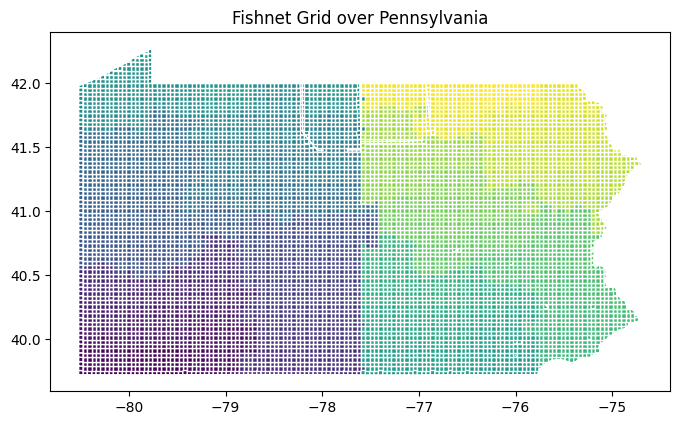

In [ ]:
# Visualize Fishnet
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Fishnet Grid over Pennsylvania')
pa_fishnet.plot(ax=ax, cmap='viridis', edgecolor='white')
plt.show()

### Load Processed Fishnet Data Below (Optional)

Alternatively, you may also load in the `pa_fishnet` file directly from our GitHub repository to save time.

In [ ]:
pa_fishnet = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/pa_fishnet.geojson')

## **3. Remote Sensing Data**

In [ ]:
## Define Time Period
startSpring = datetime(2022, 3, 1) # spring
endSpring = datetime(2022, 5, 31)
startSummer = datetime(2022, 6, 1) # summer
endSummer = datetime(2022, 8, 31)
startFall = datetime(2022, 9, 1) # fall
endFall = datetime(2022, 11, 30)
startWinter = datetime(2022, 12, 1) # winter
endWinter = datetime(2023, 2, 28)

# Format dates into strings that Earth Engine expects ("YYYY-MM-DD")
startSpring= startSpring.strftime('%Y-%m-%d')
endSpring = endSpring.strftime('%Y-%m-%d')
startSummer = startSummer.strftime('%Y-%m-%d')
endSummer = endSummer.strftime('%Y-%m-%d')
startFall = startFall.strftime('%Y-%m-%d')
endFall = endFall.strftime('%Y-%m-%d')
startWinter = startWinter.strftime('%Y-%m-%d')
endWinter = endWinter.strftime('%Y-%m-%d')

In [ ]:
## Helper Function - Scale Bands
def apply_scale_factors(image):
    # Scale and offset values for optical bands
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    # Scale and offset values for thermal bands
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

    # Add scaled bands to the original image
    return image.addBands(optical_bands, None, True) \
                .addBands(thermal_bands, None, True)

In [ ]:
## Helper Function - Mask Clouds
def cloud_mask(image):
    # Define cloud shadow and cloud bitmask (Bits 3 and 5)
    cloud_shadow_bit_mask = 1 << 3
    cloud_bit_mask = 1 << 5

    # Select the Quality Assessment (QA) band for pixel quality information
    qa = image.select('QA_PIXEL')

    # Create a binary mask to identify clear conditions (both cloud and cloud shadow bits set to 0)
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
                .And(qa.bitwiseAnd(cloud_bit_mask).eq(0))

    # Update the original image, masking out cloud and cloud shadow-affected pixels
    return image.updateMask(mask)

### **3.1 Prepare Spring Data**

In [ ]:
## Load Spring Image Collection
imageSpring = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(aoi) \
            .filterDate(startSpring, endSpring) \
            .map(apply_scale_factors) \
            .map(cloud_mask) \
            .median() \
            .clip(aoi)

In [ ]:
## Visualize Spring Image Collection
Map = geemap.Map()
Map.addLayer(aoi, {}, 'AOI')
Map.centerObject(aoi, 10)

visualization = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.15,
}
Map.addLayer(imageSpring, visualization, 'True Color 432')
Map

Map(center=[40.87803725801284, -77.79905126418927], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
## Calculate Normalized Difference Vegetation Index (NDVI)
ndvi_spring = imageSpring.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

In [ ]:
## Compute Soil Adjusted Vegetation Index (SAVI)
savi_spring = imageSpring.expression(
        '1.5 * (NIR - RED) / (NIR + RED + 0.5)', {
            'NIR': imageSpring.select('SR_B5'),
            'RED': imageSpring.select('SR_B4')
        }
    ).rename('SAVI')

In [ ]:
## Calculate Enhanced Vegetation Index (EVI)
evi_spring = imageSpring.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': imageSpring.select('SR_B5'),  # Near-Infrared (NIR) band
        'RED': imageSpring.select('SR_B4'),  # Red band
        'BLUE': imageSpring.select('SR_B2')  # Blue band
    }).rename('EVI')

In [ ]:
## Compute the Land Surface Temperature

# Calculate the minimum and maximum NDVI values within the AOI
ndvi_min = ndvi_spring.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')

ndvi_max = ndvi_spring.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')

# Convert NDVI_min and NDVI_max to ee.Number for operations
ndvi_min = ee.Number(ndvi_min)
ndvi_max = ee.Number(ndvi_max)

# Fraction of Vegetation (FV) Calculation
# Formula: ((NDVI - NDVI_min) / (NDVI_max - NDVI_min))^2
fv = ndvi_spring.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')

# Emissivity Calculation
# Formula: 0.004 * FV + 0.986
em = fv.multiply(0.004).add(0.986).rename('EM')

# Select Thermal Band (Band 10) and Rename It
thermal = imageSpring.select('ST_B10').rename('thermal')

lst_spring = thermal.expression(
    '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15',
    {
        'TB': thermal.select('thermal'),  # Thermal band as the temperature in Kelvin
        'em': em  # Emissivity
    }
).rename('LST')

In [ ]:
## Get Individual Band Information
band1_spring = imageSpring.select('SR_B1').rename('B1')
band2_spring = imageSpring.select('SR_B2').rename('B2')
band3_spring = imageSpring.select('SR_B3').rename('B3')
band4_spring = imageSpring.select('SR_B4').rename('B4')
band5_spring = imageSpring.select('SR_B5').rename('B5')
band6_spring = imageSpring.select('SR_B6').rename('B6')
band7_spring = imageSpring.select('SR_B7').rename('B7')

In [ ]:
## Helper Function - Zonal Statistics
def export_zonal_stats(image, reducer, index_name):
    zonal_stats = image.reduceRegions(
        collection=pa_fishnet_ee,
        reducer=reducer,
        scale=30
    )

    task = ee.batch.Export.table.toDrive(
        collection=zonal_stats,
        description=index_name,
        fileFormat='CSV',
        folder='remote-sensing-final' # default to our shared google drive for the project
    )
    task.start()

In [ ]:
## Apply Zonal Statistics
#### -------- DO NOT RUN THIS CODE CHUNK IF YOU WANT TO REPRODUCE THE RESULT AS IT WILL SAVE FILES TO GOOGLE DRIVE BY DEFAULT -----------
reducer = ee.Reducer.mean()
pa_fishnet_ee = geemap.geopandas_to_ee(pa_fishnet)
indices = {
    'ndvi_spring': ndvi_spring,
    'evi_spring': evi_spring,
    'lst_spring': lst_spring,
    'savi_spring': savi_spring,
    'band1_spring': band1_spring,
    'band2_spring': band2_spring,
    'band3_spring': band3_spring,
    'band4_spring': band4_spring,
    'band5_spring': band5_spring,
    'band6_spring': band6_spring,
    'band7_spring': band7_spring
}

for index_name, index_image in indices.items():
    export_zonal_stats(index_image, reducer, index_name)

In [ ]:
#### --------------- INSTEAD, PLEASE LOAD THE RESULTS DIRECTLY FORM OUR REPO --------------------------
ndvi_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/ndvi_spring.csv')
evi_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/evi_spring.csv')
savi_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/savi_spring.csv')
lst_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/lst_spring.csv')
band1_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band1_spring.csv')
band2_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band2_spring.csv')
band3_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band3_spring.csv')
band4_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band4_spring.csv')
band5_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band5_spring.csv')
band6_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band6_spring.csv')
band7_spring_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band7_spring.csv')

In [ ]:
## Combine Spring Dataframes
spring_dfs = [ndvi_spring_df,
       evi_spring_df,
       savi_spring_df,
       lst_spring_df,
       band1_spring_df,
       band2_spring_df,
       band3_spring_df,
       band4_spring_df,
       band5_spring_df,
       band6_spring_df,
       band7_spring_df]

# starting dataframe
spring_final = spring_dfs[0]
df_names = ['ndvi', 'evi', 'savi', 'lst', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']

# merge the rest of the dataframes to the starting dataframe
for df, name in zip(spring_dfs[1:], df_names[1:]):
    df.drop(columns=['.geo'], inplace=True)
    new_mean_column_name = f"{name}_mean"  # Form the new column name
    df.rename(columns={'mean': new_mean_column_name}, inplace=True)
    spring_final = pd.merge(spring_final, df, on='system:index', how='left')

spring_final.rename(columns={'mean': 'ndvi_mean'}, inplace=True)
spring_final.rename(columns={'system:index': 'NetID'}, inplace=True)
spring_final['geometry'] = spring_final['.geo'].apply(lambda x: shape(json.loads(x)))
spring_final_geom = gpd.GeoDataFrame(spring_final, geometry='geometry')

In [ ]:
## Check Data
spring_final.head()

,NetID,ndvi_mean,.geo,evi_mean,savi_mean,lst_mean,band1_mean,band2_mean,band3_mean,band4_mean,band5_mean,band6_mean,band7_mean,geometry
0,0,0.582499,"{""type"":""Polygon"",""coordinates"":[[[-79.6210697...",0.317203,0.319262,17.863170,0.029108,0.034328,0.058367,0.061290,0.233169,0.214483,0.130735,POLYGON ((-79.62106979445613 39.75439960369839...
1,1,0.560937,"{""type"":""Polygon"",""coordinates"":[[[-79.5312382...",0.329028,0.331427,23.108124,0.031836,0.039398,0.067888,0.075006,0.260516,0.243111,0.149953,POLYGON ((-79.53123826604418 39.75439960369839...
2,2,0.613952,"{""type"":""Polygon"",""coordinates"":[[[-79.5761540...",0.327202,0.332131,19.105744,0.025416,0.029897,0.054197,0.054988,0.230909,0.201132,0.116945,POLYGON ((-79.57615403025017 39.75439960369839...
3,3,0.555680,"{""type"":""Polygon"",""coordinates"":[[[-79.4863225...",0.326954,0.329579,21.033911,0.030800,0.038006,0.064880,0.073164,0.258100,0.240018,0.149894,POLYGON ((-79.48632250183822 39.75439960369839...
4,4,0.547725,"{""type"":""Polygon"",""coordinates"":[[[-79.4414067...",0.303537,0.305277,19.811644,0.028708,0.034169,0.058865,0.060915,0.226415,0.215652,0.132315,POLYGON ((-79.44140673763222 39.75439960369839...


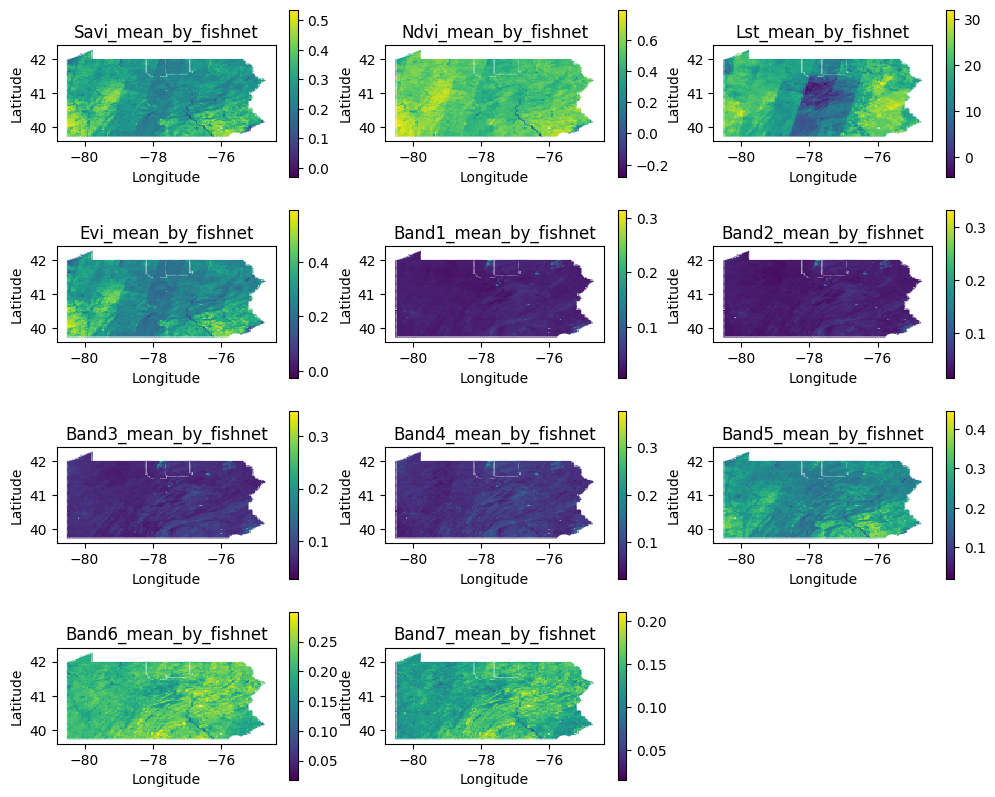

In [ ]:
## Visualizing Variables for Spring
columns_to_plot = ['savi_mean', 'ndvi_mean', 'lst_mean', 'evi_mean', 'band1_mean', 'band2_mean', 'band3_mean', 'band4_mean', 'band5_mean', 'band6_mean', 'band7_mean']

num_plots = len(columns_to_plot)
num_cols = 3  #
num_rows = num_plots // num_cols + (1 if num_plots % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
if num_rows > 1:
    axes = axes.flatten()

# Loop over the columns and plot each variable as small multiples
for i, column in enumerate(columns_to_plot):
    row_index = i // num_cols
    col_index = i % num_cols
    spring_final_geom.plot(column=column, cmap='viridis', legend=True, ax=axes[i])

    axes[i].set_title(f'{column.capitalize()}_by_fishnet')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')

# Remove empty subplots if necessary
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.show()


### **3.2 Prepare Summer Data**

In [ ]:
imageSummer = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(aoi) \
            .filterDate(startSummer, endSummer) \
            .map(apply_scale_factors) \
            .map(cloud_mask) \
            .median() \
            .clip(aoi)

In [ ]:
ndvi_summer = imageSummer.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
savi_summer = imageSummer.expression(
        '1.5 * (NIR - RED) / (NIR + RED + 0.5)', {
            'NIR': imageSummer.select('SR_B5'),
            'RED': imageSummer.select('SR_B4')
        }
    ).rename('SAVI')
evi_summer = imageSummer.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': imageSummer.select('SR_B5'),
        'RED': imageSummer.select('SR_B4'),
        'BLUE': imageSummer.select('SR_B2')
    }).rename('EVI')
ndvi_min = ndvi_summer.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_max = ndvi_summer.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_min = ee.Number(ndvi_min)
ndvi_max = ee.Number(ndvi_max)
fv = ndvi_summer.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = imageSummer.select('ST_B10').rename('thermal')
lst_summer = thermal.expression(
    '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15',
    {
        'TB': thermal.select('thermal'),
        'em': em
    }
).rename('LST')

In [ ]:
band1_summer = imageSummer.select('SR_B1').rename('B1')
band2_summer = imageSummer.select('SR_B2').rename('B2')
band3_summer = imageSummer.select('SR_B3').rename('B3')
band4_summer = imageSummer.select('SR_B4').rename('B4')
band5_summer = imageSummer.select('SR_B5').rename('B5')
band6_summer = imageSummer.select('SR_B6').rename('B6')
band7_summer = imageSummer.select('SR_B7').rename('B7')

In [ ]:
#### -------- DO NOT RUN THIS CODE CHUNK IF YOU WANT TO REPRODUCE THE RESULT AS IT WILL SAVE FILES TO GOOGLE DRIVE BY DEFAULT -----------
indices = {
    'ndvi_summer': ndvi_summer,
    'evi_summer': evi_summer,
    'lst_summer': lst_summer,
    'savi_summer': savi_summer,
    'band1_summer': band1_summer,
    'band2_summer': band2_summer,
    'band3_summer': band3_summer,
    'band4_summer': band4_summer,
    'band5_summer': band5_summer,
    'band6_summer': band6_summer,
    'band7_summer': band7_summer
}

for index_name, index_image in indices.items():
    export_zonal_stats(index_image, reducer, index_name)

In [ ]:
#### --------------- INSTEAD, PLEASE LOAD THE RESULTS DIRECTLY FORM OUR REPO --------------------------
ndvi_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/ndvi_summer.csv')
evi_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/evi_summer.csv')
savi_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/savi_summer.csv')
lst_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/lst_summer.csv')
band1_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band1_summer.csv')
band2_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band2_summer.csv')
band3_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band3_summer.csv')
band4_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band4_summer.csv')
band5_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band5_summer.csv')
band6_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band6_summer.csv')
band7_summer_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band7_summer.csv')

In [ ]:
summer_dfs = [ndvi_summer_df,
       evi_summer_df,
       savi_summer_df,
       lst_summer_df,
       band1_summer_df,
       band2_summer_df,
       band3_summer_df,
       band4_summer_df,
       band5_summer_df,
       band6_summer_df,
       band7_summer_df]
summer_final = summer_dfs[0]
df_names = ['ndvi', 'evi', 'savi', 'lst', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']

for df, name in zip(summer_dfs[1:], df_names[1:]):
    df.drop(columns=['.geo'], inplace=True)
    new_mean_column_name = f"{name}_mean"
    df.rename(columns={'mean': new_mean_column_name}, inplace=True)
    summer_final = pd.merge(summer_final, df, on='system:index', how='left')

summer_final.rename(columns={'mean': 'ndvi_mean'}, inplace=True)
summer_final.rename(columns={'system:index': 'NetID'}, inplace=True)
summer_final['geometry'] = summer_final['.geo'].apply(lambda x: shape(json.loads(x)))
summer_final_geom = gpd.GeoDataFrame(summer_final, geometry='geometry')

### **3.3 Prepare Fall Data**

In [ ]:
imageFall = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(aoi) \
            .filterDate(startFall, endFall) \
            .map(apply_scale_factors) \
            .map(cloud_mask) \
            .median() \
            .clip(aoi)

In [ ]:
ndvi_fall = imageFall.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
savi_fall = imageFall.expression(
        '1.5 * (NIR - RED) / (NIR + RED + 0.5)', {
            'NIR': imageFall.select('SR_B5'),
            'RED': imageFall.select('SR_B4')
        }
    ).rename('SAVI')
evi_fall = imageFall.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': imageFall.select('SR_B5'),
        'RED': imageFall.select('SR_B4'),
        'BLUE': imageFall.select('SR_B2')
    }).rename('EVI')
ndvi_min = ndvi_fall.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_max = ndvi_fall.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_min = ee.Number(ndvi_min)
ndvi_max = ee.Number(ndvi_max)
fv = ndvi_fall.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = imageFall.select('ST_B10').rename('thermal')
lst_fall = thermal.expression(
    '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15',
    {
        'TB': thermal.select('thermal'),
        'em': em
    }
).rename('LST')

In [ ]:
band1_fall = imageFall.select('SR_B1').rename('B1')
band2_fall = imageFall.select('SR_B2').rename('B2')
band3_fall = imageFall.select('SR_B3').rename('B3')
band4_fall = imageFall.select('SR_B4').rename('B4')
band5_fall = imageFall.select('SR_B5').rename('B5')
band6_fall = imageFall.select('SR_B6').rename('B6')
band7_fall = imageFall.select('SR_B7').rename('B7')

In [ ]:
#### -------- DO NOT RUN THIS CODE CHUNK IF YOU WANT TO REPRODUCE THE RESULT AS IT WILL SAVE FILES TO GOOGLE DRIVE BY DEFAULT -----------
indices = {
    'ndvi_fall': ndvi_fall,
    'evi_fall': evi_fall,
    'lst_fall': lst_fall,
    'savi_fall': savi_fall,
    'band1_fall': band1_fall,
    'band2_fall': band2_fall,
    'band3_fall': band3_fall,
    'band4_fall': band4_fall,
    'band5_fall': band5_fall,
    'band6_fall': band6_fall,
    'band7_fall': band7_fall
}

for index_name, index_image in indices.items():
    export_zonal_stats(index_image, reducer, index_name)

In [ ]:
#### --------------- INSTEAD, PLEASE LOAD THE RESULTS DIRECTLY FORM OUR REPO --------------------------
ndvi_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/ndvi_fall.csv')
evi_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/evi_fall.csv')
savi_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/savi_fall.csv')
lst_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/lst_fall.csv')
band1_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band1_fall.csv')
band2_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band2_fall.csv')
band3_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band3_fall.csv')
band4_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band4_fall.csv')
band5_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band5_fall.csv')
band6_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band6_fall.csv')
band7_fall_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band7_fall.csv')

In [ ]:
fall_dfs = [ndvi_fall_df,
       evi_fall_df,
       savi_fall_df,
       lst_fall_df,
       band1_fall_df,
       band2_fall_df,
       band3_fall_df,
       band4_fall_df,
       band5_fall_df,
       band6_fall_df,
       band7_fall_df]
fall_final = fall_dfs[0]
df_names = ['ndvi', 'evi', 'savi', 'lst', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']

for df, name in zip(fall_dfs[1:], df_names[1:]):
    df.drop(columns=['.geo'], inplace=True)
    new_mean_column_name = f"{name}_mean"
    df.rename(columns={'mean': new_mean_column_name}, inplace=True)
    fall_final = pd.merge(fall_final, df, on='system:index', how='left')

fall_final.rename(columns={'mean': 'ndvi_mean'}, inplace=True)
fall_final.rename(columns={'system:index': 'NetID'}, inplace=True)
fall_final['geometry'] = fall_final['.geo'].apply(lambda x: shape(json.loads(x)))
fall_final_geom = gpd.GeoDataFrame(fall_final, geometry='geometry')

### **3.4 Prepare Winter Data**

In [ ]:
imageWinter = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(aoi) \
            .filterDate(startWinter, endWinter) \
            .map(apply_scale_factors) \
            .map(cloud_mask) \
            .median() \
            .clip(aoi)

In [ ]:
ndvi_winter = imageWinter.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
savi_winter = imageWinter.expression(
        '1.5 * (NIR - RED) / (NIR + RED + 0.5)', {
            'NIR': imageWinter.select('SR_B5'),
            'RED': imageWinter.select('SR_B4')
        }
    ).rename('SAVI')
evi_winter = imageWinter.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': imageWinter.select('SR_B5'),
        'RED': imageWinter.select('SR_B4'),
        'BLUE': imageWinter.select('SR_B2')
    }).rename('EVI')
ndvi_min = ndvi_winter.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_max = ndvi_winter.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('NDVI')
ndvi_min = ee.Number(ndvi_min)
ndvi_max = ee.Number(ndvi_max)
fv = ndvi_winter.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = imageWinter.select('ST_B10').rename('thermal')
lst_winter = thermal.expression(
    '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15',
    {
        'TB': thermal.select('thermal'),
        'em': em
    }
).rename('LST')

In [ ]:
band1_winter = imageWinter.select('SR_B1').rename('B1')
band2_winter = imageWinter.select('SR_B2').rename('B2')
band3_winter = imageWinter.select('SR_B3').rename('B3')
band4_winter = imageWinter.select('SR_B4').rename('B4')
band5_winter = imageWinter.select('SR_B5').rename('B5')
band6_winter = imageWinter.select('SR_B6').rename('B6')
band7_winter = imageWinter.select('SR_B7').rename('B7')

In [ ]:
#### -------- DO NOT RUN THIS CODE CHUNK IF YOU WANT TO REPRODUCE THE RESULT AS IT WILL SAVE FILES TO GOOGLE DRIVE BY DEFAULT -----------
indices = {
    'ndvi_winter': ndvi_winter,
    'evi_winter': evi_winter,
    'lst_winter': lst_winter,
    'savi_winter': savi_winter,
    'band1_winter': band1_winter,
    'band2_winter': band2_winter,
    'band3_winter': band3_winter,
    'band4_winter': band4_winter,
    'band5_winter': band5_winter,
    'band6_winter': band6_winter,
    'band7_winter': band7_winter
}

for index_name, index_image in indices.items():
    export_zonal_stats(index_image, reducer, index_name)

In [ ]:
#### --------------- INSTEAD, PLEASE LOAD THE RESULTS DIRECTLY FORM OUR REPO --------------------------
ndvi_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/ndvi_winter.csv')
evi_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/evi_winter.csv')
savi_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/savi_winter.csv')
lst_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/lst_winter.csv')
band1_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band1_winter.csv')
band2_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band2_winter.csv')
band3_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band3_winter.csv')
band4_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band4_winter.csv')
band5_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band5_winter.csv')
band6_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band6_winter.csv')
band7_winter_df = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/band7_winter.csv')

In [ ]:
winter_dfs = [ndvi_winter_df,
       evi_winter_df,
       savi_winter_df,
       lst_winter_df,
       band1_winter_df,
       band2_winter_df,
       band3_winter_df,
       band4_winter_df,
       band5_winter_df,
       band6_winter_df,
       band7_winter_df]
winter_final = winter_dfs[0]
df_names = ['ndvi', 'evi', 'savi', 'lst', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']

for df, name in zip(winter_dfs[1:], df_names[1:]):
    df.drop(columns=['.geo'], inplace=True)
    new_mean_column_name = f"{name}_mean"
    df.rename(columns={'mean': new_mean_column_name}, inplace=True)
    winter_final = pd.merge(winter_final, df, on='system:index', how='left')

winter_final.rename(columns={'mean': 'ndvi_mean'}, inplace=True)
winter_final.rename(columns={'system:index': 'NetID'}, inplace=True)
winter_final['geometry'] = winter_final['.geo'].apply(lambda x: shape(json.loads(x)))
winter_final_geom = gpd.GeoDataFrame(winter_final, geometry='geometry')

### Load Processed Remote Sensing Data Below (Optional)


In [ ]:
## PLAIN TABULAR DATA
spring_final = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/spring_final.csv')
summer_final = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/summer_final.csv')
fall_final = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/fall_final.csv')
winter_final = pd.read_csv('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/winter_final.csv')

## GEOJSON DATA
spring_final_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/spring_final_geom.geojson')
summer_final_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/summer_final_geom.geojson')
fall_final_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/winter_final_geom.geojson')
winter_final_geom = gpd.read_file('https://raw.githubusercontent.com/emilyzhou112/MUSA6500-Pennsylvania-CRD/main/data/derived/winter_final_geom.geojson')

## **4. Hospital Discharge Data**
Hospitalization Discharges due to Chronic lower respiratory diseases: Age-Adjusted Rates are standardized to the year 2000 US million population


In [ ]:
hospital_raw = pd.read_csv('/content/drive/MyDrive/remote-sensing-final/HospitalizationDischarges.csv')
hospital_clean = hospital_raw[['Geography', 'Count', 'Geography_Code', 'Population']]
hospital_clean['Geography'] = hospital_clean['Geography'].str.lower()  # Convert values to lowercase

In [ ]:
pa_clean = pa[['fips_count', 'county_nam', 'geometry']]
pa_clean['Geography'] = pa_clean['county_nam'].str.lower()  # Convert values to lowercase
pa_clean = pa_clean.drop(columns=['county_nam'])

In [ ]:
county_discharge = pd.merge(pa_clean, hospital_clean, on='Geography', how='left')

### **4.1 Aggregate Hospital Data to Fishnet**

In [ ]:
id = len(pa_fishnet.index)
pa_fishnet['id'] = range(0, id)
fishpoint = pa_fishnet.copy()
fishpoint['centroid'] = fishpoint.geometry.centroid
fishpoint.drop(columns=['geometry'], inplace=True)
fishpoint.rename(columns={'centroid': 'geometry'}, inplace=True)

In [ ]:
# if points fall within a county, give the name of the county, join with it
fishpoint_discharge = gpd.sjoin(fishpoint, county_discharge, how='left', op='intersects')
# bring points back to net
fishpoint_discharge.drop(columns=['geometry'], inplace=True)
fishnet_discharge = pd.merge(pa_fishnet, fishpoint_discharge, on='id', how='left')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
# Find the rows where the "Count" column is null
null_rows = fishnet_discharge[fishnet_discharge['Count'].isnull()]
print(null_rows)

                                               geometry    id  index_right  \
4326  MULTIPOLYGON (((-80.11514 42.16226, -80.07840 ...  4326          NaN   
5926  MULTIPOLYGON (((-75.03966 40.40934, -75.03964 ...  5926          NaN   
6150  MULTIPOLYGON (((-75.08458 40.82862, -75.08452 ...  6150          NaN   
7283  POLYGON ((-74.99475 41.12175, -74.95051 41.121...  7283          NaN   
7988  MULTIPOLYGON (((-75.26424 41.86927, -75.26421 ...  7988          NaN   

     fips_count Geography Count  Geography_Code Population  
4326        NaN       NaN   NaN             NaN        NaN  
5926        NaN       NaN   NaN             NaN        NaN  
6150        NaN       NaN   NaN             NaN        NaN  
7283        NaN       NaN   NaN             NaN        NaN  
7988        NaN       NaN   NaN             NaN        NaN  


In [ ]:
fishnet_discharge['Count'] = pd.to_numeric(fishnet_discharge['Count'], errors='coerce')
fishnet_discharge['Population'] = fishnet_discharge['Population'].str.replace(',', '')
fishnet_discharge['Population'] = pd.to_numeric(fishnet_discharge['Population'], errors='coerce')
fishnet_discharge['CRD_Rate'] = fishnet_discharge['Count'] / fishnet_discharge['Population'] * 1000

### **4.2 Combine Hospital Data and Remote Sensing Data**

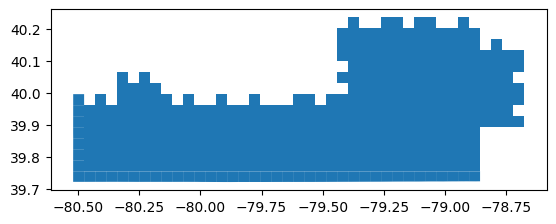

In [ ]:
filtered_net = fishnet_discharge.head(400)
filtered_net.plot()
plt.show()

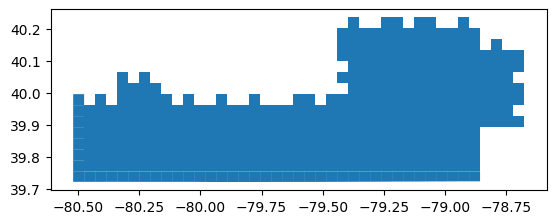

In [ ]:
filtered_spring = spring_final_geom.head(400)
filtered_spring.plot()
plt.show()

In [ ]:
spring_discharge_bynet = pd.merge(fishnet_discharge, spring_final, left_on='id', right_on='NetID', how='left')
spring_discharge_bynet.dropna(subset=['CRD_Rate'], inplace=True)
summer_discharge_bynet = pd.merge(fishnet_discharge, summer_final, left_on='id', right_on='NetID', how='left')
summer_discharge_bynet.dropna(subset=['CRD_Rate'], inplace=True)
fall_discharge_bynet = pd.merge(fishnet_discharge, fall_final, left_on='id', right_on='NetID', how='left')
fall_discharge_bynet.dropna(subset=['CRD_Rate'], inplace=True)
winter_discharge_bynet = pd.merge(fishnet_discharge, winter_final, left_on='id', right_on='NetID', how='left')
winter_discharge_bynet.dropna(subset=['CRD_Rate'], inplace=True

## **5. Air Quality Data**

### **5.1 Process and Aggregate PM2.5 Data**

In [ ]:
pm25_raw = pd.read_csv('/content/drive/MyDrive/remote-sensing-final/AQ-Data-PM25.csv')
pm25_geom = gpd.GeoDataFrame(pm25_raw, geometry=gpd.points_from_xy(pm25_raw['Longitude'], pm25_raw['Latitude']))
pm25_geom.crs = {'init': 'epsg:4326'}
pm25_geom.to_file('/content/drive/MyDrive/remote-sensing-final/pm25_geom.geojson', driver='GeoJSON')

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

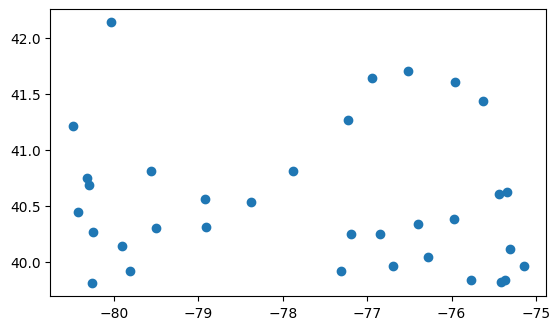

In [ ]:
pm25_geom.plot()

In [ ]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [ ]:
pm25_coords = np.column_stack((pm25_geom.geometry.x, pm25_geom.geometry.y))
vor_pm25 = Voronoi(pm25_coords)
regions_pm25, vertices_pm25 = voronoi_finite_polygons_2d(vor_pm25)

In [ ]:
clipped_voronoi_polygons = []
for region in regions_pm25:
    polygon = vertices_pm25[region]
    poly = Polygon(polygon)
    clipped_poly = poly.intersection(pa_bound.geometry.unary_union)
    if clipped_poly.is_empty:
        continue
    clipped_voronoi_polygons.append(clipped_poly)

# Create a GeoDataFrame from the list of clipped Voronoi polygons
voronoi_pm25 = gpd.GeoDataFrame(geometry=clipped_voronoi_polygons, crs=pa_bound.crs)
voronoi_pm25.to_file('/content/drive/MyDrive/remote-sensing-final/vorpm25', driver='GeoJSON')

In [ ]:
voronoi_pm25_geom = gpd.sjoin(voronoi_pm25,pm25_geom, op='intersects')
voronoi_pm25_geom.drop(columns=['index_right', 'Latitude', 'Longitude'], inplace=True)

In [ ]:
fishpoint_vor_pm25 = gpd.sjoin(fishpoint, voronoi_pm25_geom, how='left', op='intersects')
fishpoint_vor_pm25.drop(columns=['geometry'], inplace=True)
fishnet_pm25 = pd.merge(pa_fishnet, fishpoint_vor_pm25, on='id', how='left')

In [ ]:
spring_discharge_bynet = pd.merge(spring_discharge_bynet, fishnet_pm25[['id', 'Spring']], left_on='id', right_on='id', how='left')
summer_discharge_bynet = pd.merge(summer_discharge_bynet, fishnet_pm25[['id', 'Summer']], left_on='id', right_on='id', how='left')
fall_discharge_bynet = pd.merge(fall_discharge_bynet, fishnet_pm25[['id', 'Fall']], left_on='id', right_on='id', how='left')
winter_discharge_bynet = pd.merge(winter_discharge_bynet, fishnet_pm25[['id', 'Winter']], left_on='id', right_on='id', how='left')

In [ ]:
spring_discharge_bynet.rename(columns={'Spring': 'PM25'}, inplace=True)
summer_discharge_bynet.rename(columns={'Summer': 'PM25'}, inplace=True)
fall_discharge_bynet.rename(columns={'Fall': 'PM25'}, inplace=True)
winter_discharge_bynet.rename(columns={'Winter': 'PM25'}, inplace=True)

In [ ]:
spring_discharge_bynet.drop(columns=['geometry_y'], inplace=True)
summer_discharge_bynet.drop(columns=['geometry_y'], inplace=True)
fall_discharge_bynet.drop(columns=['geometry_y'], inplace=True)
winter_discharge_bynet.drop(columns=['geometry_y'], inplace=True)

### **5.2 Process and Aggregate O3 Data**

In [ ]:
o3_raw = pd.read_csv('/content/drive/MyDrive/remote-sensing-final/AQ-Data-O3.csv')
o3_geom = gpd.GeoDataFrame(o3_raw, geometry=gpd.points_from_xy(o3_raw['Longitude'], o3_raw['Latitude']))
o3_geom.crs = {'init': 'epsg:4326'}
o3_geom.to_file('/content/drive/MyDrive/remote-sensing-final/o3_geom.geojson', driver='GeoJSON')

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
o3_coords = np.column_stack((o3_geom.geometry.x, o3_geom.geometry.y))
vor_o3 = Voronoi(o3_coords)
regions_o3, vertices_o3 = voronoi_finite_polygons_2d(vor_o3)

In [ ]:
clipped_voronoi_polygons = []
for region in regions_o3:
    polygon = vertices_o3[region]
    poly = Polygon(polygon)
    clipped_poly = poly.intersection(pa_bound.geometry.unary_union)
    if clipped_poly.is_empty:
        continue
    clipped_voronoi_polygons.append(clipped_poly)

# Create a GeoDataFrame from the list of clipped Voronoi polygons
voronoi_o3 = gpd.GeoDataFrame(geometry=clipped_voronoi_polygons, crs=pa_bound.crs)
voronoi_o3.to_file('/content/drive/MyDrive/remote-sensing-final/voro3', driver='GeoJSON')

In [ ]:
voronoi_o3_geom = gpd.sjoin(voronoi_o3,o3_geom, op='intersects')
voronoi_o3_geom.drop(columns=['index_right', 'Latitude', 'Longitude'], inplace=True)

In [ ]:
fishpoint_vor_o3 = gpd.sjoin(fishpoint, voronoi_o3_geom, how='left', op='intersects')
fishpoint_vor_o3.drop(columns=['geometry'], inplace=True)
fishnet_o3 = pd.merge(pa_fishnet, fishpoint_vor_o3, on='id', how='left')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
spring_discharge_bynet = pd.merge(spring_discharge_bynet, fishnet_o3[['id', 'Spring']], left_on='id', right_on='id', how='left')
summer_discharge_bynet = pd.merge(summer_discharge_bynet, fishnet_o3[['id', 'Summer']], left_on='id', right_on='id', how='left')
fall_discharge_bynet = pd.merge(fall_discharge_bynet, fishnet_o3[['id', 'Fall']], left_on='id', right_on='id', how='left')
winter_discharge_bynet = pd.merge(winter_discharge_bynet, fishnet_o3[['id', 'Winter']], left_on='id', right_on='id', how='left')

In [ ]:
spring_discharge_bynet.rename(columns={'Spring': 'O3'}, inplace=True)
summer_discharge_bynet.rename(columns={'Summer': 'O3'}, inplace=True)
fall_discharge_bynet.rename(columns={'Fall': 'O3'}, inplace=True)
winter_discharge_bynet.rename(columns={'Winter': 'O3'}, inplace=True)

### **5.3 Process and Aggregate Wind Speed Data**

In [ ]:
ws_raw = pd.read_csv('/content/drive/MyDrive/remote-sensing-final/AQ-Data-WS.csv')
ws_geom = gpd.GeoDataFrame(ws_raw, geometry=gpd.points_from_xy(ws_raw['Longitude'], ws_raw['Latitude']))
ws_geom.crs = {'init': 'epsg:4326'}
ws_geom.to_file('/content/drive/MyDrive/remote-sensing-final/ws_geom.geojson', driver='GeoJSON')

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
ws_coords = np.column_stack((ws_geom.geometry.x, ws_geom.geometry.y))
vor_ws = Voronoi(ws_coords)
regions_ws, vertices_ws = voronoi_finite_polygons_2d(vor_ws)

In [ ]:
clipped_voronoi_polygons = []
for region in regions_ws:
    polygon = vertices_ws[region]
    poly = Polygon(polygon)
    clipped_poly = poly.intersection(pa_bound.geometry.unary_union)
    if clipped_poly.is_empty:
        continue
    clipped_voronoi_polygons.append(clipped_poly)

voronoi_ws = gpd.GeoDataFrame(geometry=clipped_voronoi_polygons, crs=pa_bound.crs)
voronoi_ws.to_file('/content/drive/MyDrive/remote-sensing-final/vorws', driver='GeoJSON')

In [ ]:
voronoi_ws_geom = gpd.sjoin(voronoi_ws,ws_geom, op='intersects')
voronoi_ws_geom.drop(columns=['index_right', 'Latitude', 'Longitude'], inplace=True)

In [ ]:
fishpoint_vor_ws = gpd.sjoin(fishpoint, voronoi_ws_geom, how='left', op='intersects')
fishpoint_vor_ws.drop(columns=['geometry'], inplace=True)
fishnet_ws = pd.merge(pa_fishnet, fishpoint_vor_ws, on='id', how='left')

In [ ]:
spring_discharge_bynet = pd.merge(spring_discharge_bynet, fishnet_ws[['id', 'Spring']], left_on='id', right_on='id', how='left')
summer_discharge_bynet = pd.merge(summer_discharge_bynet, fishnet_ws[['id', 'Summer']], left_on='id', right_on='id', how='left')
fall_discharge_bynet = pd.merge(fall_discharge_bynet, fishnet_ws[['id', 'Fall']], left_on='id', right_on='id', how='left')
winter_discharge_bynet = pd.merge(winter_discharge_bynet, fishnet_ws[['id', 'Winter']], left_on='id', right_on='id', how='left')

In [ ]:
spring_discharge_bynet.rename(columns={'Spring': 'WS'}, inplace=True)
summer_discharge_bynet.rename(columns={'Summer': 'WS'}, inplace=True)
fall_discharge_bynet.rename(columns={'Fall': 'WS'}, inplace=True)
winter_discharge_bynet.rename(columns={'Winter': 'WS'}, inplace=True)

### **5.4 Process and Aggregate Solar Radiation Data**

In [ ]:
sr_raw = pd.read_csv('/content/drive/MyDrive/remote-sensing-final/AQ-Data-SR.csv')
sr_geom = gpd.GeoDataFrame(sr_raw, geometry=gpd.points_from_xy(sr_raw['Longitude'], sr_raw['Latitude']))
sr_geom.crs = {'init': 'epsg:4326'}
sr_geom.to_file('/content/drive/MyDrive/remote-sensing-final/sr_geom.geojson', driver='GeoJSON')

In [ ]:
sr_coords = np.column_stack((sr_geom.geometry.x, sr_geom.geometry.y))
vor_sr = Voronoi(sr_coords)
regions_sr, vertices_sr = voronoi_finite_polygons_2d(vor_sr)

In [ ]:
clipped_voronoi_polygons = []
for region in regions_sr:
    polygon = vertices_sr[region]
    poly = Polygon(polygon)
    clipped_poly = poly.intersection(pa_bound.geometry.unary_union)
    if clipped_poly.is_empty:
        continue
    clipped_voronoi_polygons.append(clipped_poly)

voronoi_sr = gpd.GeoDataFrame(geometry=clipped_voronoi_polygons, crs=pa_bound.crs)
voronoi_sr.to_file('/content/drive/MyDrive/remote-sensing-final/vorsr', driver='GeoJSON')

In [ ]:
voronoi_sr_geom = gpd.sjoin(voronoi_sr,sr_geom, op='intersects')
voronoi_sr_geom.drop(columns=['index_right', 'Latitude', 'Longitude'], inplace=True)

In [ ]:
fishpoint_vor_sr = gpd.sjoin(fishpoint, voronoi_sr_geom, how='left', op='intersects')
fishpoint_vor_sr.drop(columns=['geometry'], inplace=True)
fishnet_sr = pd.merge(pa_fishnet, fishpoint_vor_sr, on='id', how='left')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
spring_discharge_bynet = pd.merge(spring_discharge_bynet, fishnet_sr[['id', 'Spring']], left_on='id', right_on='id', how='left')
summer_discharge_bynet = pd.merge(summer_discharge_bynet, fishnet_sr[['id', 'Summer']], left_on='id', right_on='id', how='left')
fall_discharge_bynet = pd.merge(fall_discharge_bynet, fishnet_sr[['id', 'Fall']], left_on='id', right_on='id', how='left')
winter_discharge_bynet = pd.merge(winter_discharge_bynet, fishnet_sr[['id', 'Winter']], left_on='id', right_on='id', how='left')

In [ ]:
spring_discharge_bynet.rename(columns={'Spring': 'SR'}, inplace=True)
summer_discharge_bynet.rename(columns={'Summer': 'SR'}, inplace=True)
fall_discharge_bynet.rename(columns={'Fall': 'SR'}, inplace=True)
winter_discharge_bynet.rename(columns={'Winter': 'SR'}, inplace=True)

In [ ]:
# Save the final files
spring_discharge_bynet.to_csv('/content/drive/MyDrive/remote-sensing-final/spring_discharge_bynet.csv')
summer_discharge_bynet.to_csv('/content/drive/MyDrive/remote-sensing-final/summer_discharge_bynet.csv')
fall_discharge_bynet.to_csv('/content/drive/MyDrive/remote-sensing-final/fall_discharge_bynet.csv')
winter_discharge_bynet.to_csv('/content/drive/MyDrive/remote-sensing-final/winter_discharge_bynet.csv')

### Load Completed Processed Data Below (Optional)


In [ ]:
import pandas as pd
spring_discharge_bynet = pd.read_csv('/content/drive/MyDrive/remote-sensing-final/spring_discharge_bynet.csv')
summer_discharge_bynet = pd.read_csv('/content/drive/MyDrive/remote-sensing-final/summer_discharge_bynet.csv')
fall_discharge_bynet = pd.read_csv('/content/drive/MyDrive/remote-sensing-final/fall_discharge_bynet.csv')
winter_discharge_bynet = pd.read_csv('/content/drive/MyDrive/remote-sensing-final/winter_discharge_bynet.csv')

## **6. Dimensionality Reduction**

In [ ]:
feature_columns  = ['savi_mean', 'ndvi_mean', 'lst_mean', 'evi_mean', 'band1_mean', 'band2_mean', 'band3_mean', 'band4_mean', 'band5_mean', 'band6_mean', 'band7_mean', 'PM25', 'O3', 'WS', 'SR']
target_column = 'CRD_Rate'

# Split the data into features and target
X = spring_discharge_bynet[feature_columns]
y = spring_discharge_bynet[target_column]

In [ ]:
def calculate_bic(y_true, y_pred, n, p):
    """Calculate Bayesian Information Criterion (BIC)."""
    mse = mean_squared_error(y_true, y_pred)
    return n * np.log(mse) + p * np.log(n)

# Step 1: Fit the full model
full_model = LinearRegression().fit(X, y)
y_pred_full = full_model.predict(X)
n_samples = len(y)
p_predictors = X.shape[1]
bic_full = calculate_bic(y, y_pred_full, n_samples, p_predictors)

# Step 2: Perform backward elimination
selected_predictors = list(X.columns)
selected_bic = bic_full

while True:
    best_bic = selected_bic
    best_predictors = selected_predictors

    for predictor in selected_predictors:
        predictors_subset = selected_predictors.copy()
        predictors_subset.remove(predictor)
        X_subset = X[predictors_subset]
        model = LinearRegression().fit(X_subset, y)
        y_pred_subset = model.predict(X_subset)
        bic = calculate_bic(y, y_pred_subset, n_samples, len(predictors_subset))
        if bic < best_bic:
            best_bic = bic
            best_predictors = predictors_subset

    if best_bic < selected_bic:
        selected_bic = best_bic
        selected_predictors = best_predictors
    else:
        break

# Print the selected predictors and their BIC
print("Selected predictors:", selected_predictors)
print("BIC:", selected_bic)


Selected predictors: ['savi_mean', 'ndvi_mean', 'lst_mean', 'evi_mean', 'band1_mean', 'band3_mean', 'band5_mean', 'band6_mean', 'PM25', 'O3', 'WS', 'SR']
BIC: -15699.097889431705


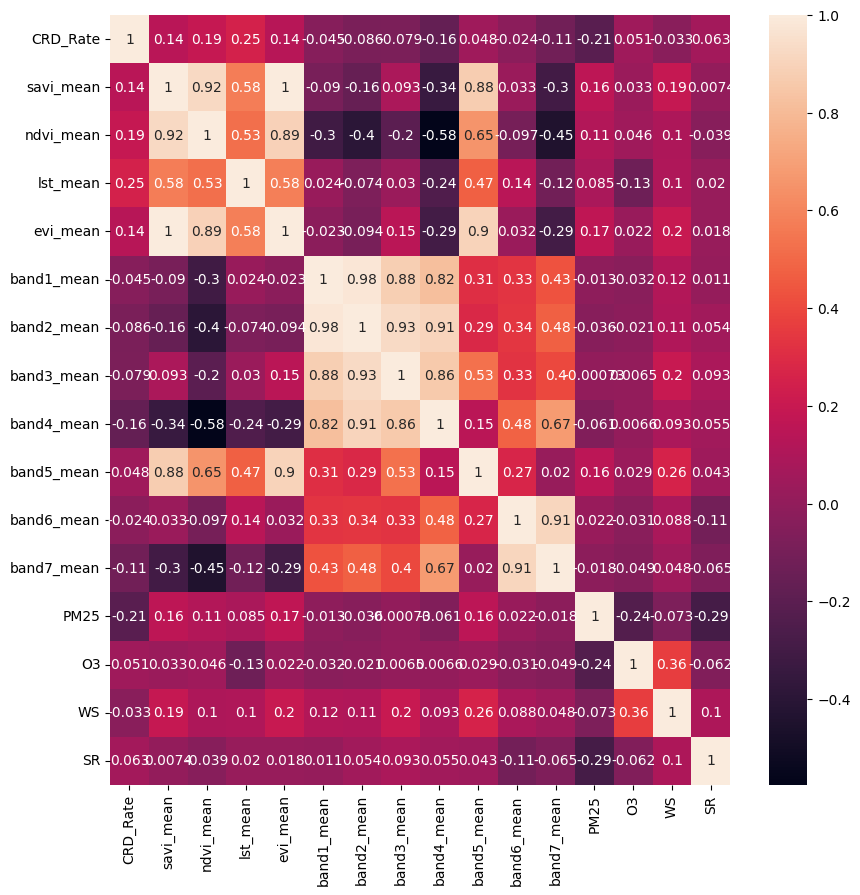

In [ ]:
spring_discharge_bynet_corr = spring_discharge_bynet[['CRD_Rate','savi_mean', 'ndvi_mean', 'lst_mean', 'evi_mean', 'band1_mean', 'band2_mean', 'band3_mean', 'band4_mean', 'band5_mean', 'band6_mean', 'band7_mean', 'PM25', 'O3', 'WS', 'SR' ]]
plt.figure(figsize=(10,10))
ax = sns.heatmap(spring_discharge_bynet_corr.corr(), annot=True)
plt.show()

## **7. Machine Learning Models**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import numpy as np

feature_columns  = ['ndvi_mean', 'lst_mean', 'evi_mean', 'band1_mean', 'band3_mean', 'band4_mean', 'band7_mean', 'PM25', 'WS', 'SR']
target_column = 'CRD_Rate'

### **7.1 Spring Data Models**

In [ ]:
### Spring Data Machine Learning
X1 = spring_discharge_bynet[feature_columns]
y1 = spring_discharge_bynet[target_column]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=spring_discharge_bynet['Geography'])

scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X1_train_scaled, y1_train)
predictions1_lr = linear_model.predict(X1_test_scaled)
mse1_lr = mean_squared_error(y1_test, predictions1_lr)
rmse1_lr = np.sqrt(mse1_lr)
r21_lr = r2_score(y1_test, predictions1_lr)
print("RMSE for LR Spring:", rmse1_lr)
print("R-squared for LR Spring:", r21_lr)

# SVM
svm_model = SVR()
svm_model.fit(X1_train_scaled, y1_train)
predictions1_svm = svm_model.predict(X1_test_scaled)
mse1_svm = mean_squared_error(y1_test, predictions1_svm)
rmse1_svm = np.sqrt(mse1_svm)
r21_svm = r2_score(y1_test, predictions1_svm)
print("RMSE for SVM Spring:", rmse1_svm)
print("R-squared for SVM Spring:", r21_svm)


# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X1_train_scaled, y1_train)
predictions1_rf = rf_model.predict(X1_test_scaled)
mse1_rf = mean_squared_error(y1_test, predictions1_rf)
rmse1_rf = np.sqrt(mse1_rf)
r21_rf = r2_score(y1_test, predictions1_rf)
print("RMSE for RF Spring:", rmse1_rf)
print("R-squared for RF Spring:", r21_rf)

# Multiple Layer Perceptron
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X1_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(1)  # Output layer
])

model1.compile(optimizer='adam', loss='mean_squared_error')
history1 = model1.fit(X1_train_scaled, y1_train, epochs=50, batch_size=32, validation_split=0.2)
predictions1_mlp = model1.predict(X1_test_scaled)
mse1_mlp = mean_squared_error(y1_test, predictions1_mlp)
rmse1_mlp = np.sqrt(mse1_mlp)
r21_mlp = r2_score(y1_test, predictions1_mlp)
print("R-squared for MLP Spring:", r21_mlp)
print("RMSE for MLP Spring:", rmse1_mlp)


RMSE for LR Spring: 0.3769626759388666
R-squared for LR Spring: 0.15211116822498838
RMSE for SVM Spring: 0.28743369962422416
R-squared for SVM Spring: 0.5070333028164766
RMSE for RF Spring: 0.2414791169392152
R-squared for RF Spring: 0.6520623951699929
Epoch 1/50
161/161 [==============================] - 3s 8ms/step - loss: 0.4279 - val_loss: 0.1809
Epoch 2/50
161/161 [==============================] - 2s 15ms/step - loss: 0.2142 - val_loss: 0.1252
Epoch 3/50
161/161 [==============================] - 1s 5ms/step - loss: 0.1750 - val_loss: 0.1098
Epoch 4/50
161/161 [==============================] - 1s 4ms/step - loss: 0.1514 - val_loss: 0.1079
Epoch 5/50
161/161 [==============================] - 1s 4ms/step - loss: 0.1476 - val_loss: 0.1073
Epoch 6/50
161/161 [==============================] - 1s 4ms/step - loss: 0.1383 - val_loss: 0.1031
Epoch 7/50
161/161 [==============================] - 1s 4ms/step - loss: 0.1337 - val_loss: 0.0996
Epoch 8/50
161/161 [==========================

### **7.2 Summer Data Model**

In [ ]:
### Summer Data Machine Learning
X2 = summer_discharge_bynet[feature_columns]
y2 = summer_discharge_bynet[target_column]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=summer_discharge_bynet['Geography'])

scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

# Linear Regression
linear_model.fit(X2_train_scaled, y2_train)
predictions2_lr = linear_model.predict(X2_test_scaled)
mse2_lr = mean_squared_error(y2_test, predictions2_lr)
rmse2_lr = np.sqrt(mse2_lr)
r22_lr = r2_score(y2_test, predictions2_lr)


# SVM
svm_model.fit(X2_train_scaled, y2_train)
predictions2_svm = svm_model.predict(X2_test_scaled)
mse2_svm = mean_squared_error(y2_test, predictions2_svm)
rmse2_svm = np.sqrt(mse2_svm)
r22_svm = r2_score(y2_test, predictions2_svm)



# Random Forest
rf_model.fit(X2_train_scaled, y2_train)
predictions2_rf = rf_model.predict(X2_test_scaled)
mse2_rf = mean_squared_error(y2_test, predictions2_rf)
rmse2_rf = np.sqrt(mse2_rf)
r22_rf = r2_score(y2_test, predictions2_rf)

# Multiple Layer Perceptron
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X2_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(1)  # Output layer
])

model2.compile(optimizer='adam', loss='mean_squared_error')
history2 = model2.fit(X2_train_scaled, y2_train, epochs=50, batch_size=32, validation_split=0.2)
predictions2_mlp = model2.predict(X2_test_scaled)
mse2_mlp = mean_squared_error(y2_test, predictions2_mlp)
rmse2_mlp = np.sqrt(mse2_mlp)
r22_mlp = r2_score(y2_test, predictions2_mlp)

Epoch 1/50
161/161 [==============================] - 2s 5ms/step - loss: 0.4013 - val_loss: 0.1722
Epoch 2/50
161/161 [==============================] - 1s 4ms/step - loss: 0.2069 - val_loss: 0.1432
Epoch 3/50
161/161 [==============================] - 1s 4ms/step - loss: 0.1757 - val_loss: 0.1317
Epoch 4/50
161/161 [==============================] - 1s 4ms/step - loss: 0.1593 - val_loss: 0.1386
Epoch 5/50
161/161 [==============================] - 1s 5ms/step - loss: 0.1516 - val_loss: 0.1258
Epoch 6/50
161/161 [==============================] - 1s 4ms/step - loss: 0.1492 - val_loss: 0.1239
Epoch 7/50
161/161 [==============================] - 1s 4ms/step - loss: 0.1453 - val_loss: 0.1220
Epoch 8/50
161/161 [==============================] - 1s 5ms/step - loss: 0.1389 - val_loss: 0.1209
Epoch 9/50
161/161 [==============================] - 2s 12ms/step - loss: 0.1372 - val_loss: 0.1168
Epoch 10/50
161/161 [==============================] - 1s 5ms/step - loss: 0.1340 - val_loss: 0.115

### **7.3 Fall Data Model**

In [ ]:
### Fall Data Machine Learning
fall_discharge_bynet = fall_discharge_bynet.dropna()
X3 = fall_discharge_bynet[feature_columns]
y3 = fall_discharge_bynet[target_column]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=fall_discharge_bynet['Geography'])

scaler = StandardScaler()
X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.transform(X3_test)

# Linear Regression
linear_model.fit(X3_train_scaled, y3_train)
predictions3_lr = linear_model.predict(X3_test_scaled)
mse3_lr = mean_squared_error(y3_test, predictions3_lr)
rmse3_lr = np.sqrt(mse3_lr)
r23_lr = r2_score(y3_test, predictions3_lr)


# SVM
svm_model.fit(X3_train_scaled, y3_train)
predictions3_svm = svm_model.predict(X3_test_scaled)
mse3_svm = mean_squared_error(y3_test, predictions3_svm)
rmse3_svm = np.sqrt(mse3_svm)
r23_svm = r2_score(y3_test, predictions3_svm)



# Random Forest
rf_model.fit(X3_train_scaled, y3_train)
predictions3_rf = rf_model.predict(X3_test_scaled)
mse3_rf = mean_squared_error(y3_test, predictions3_rf)
rmse3_rf = np.sqrt(mse3_rf)
r23_rf = r2_score(y3_test, predictions3_rf)

# Multiple Layer Perceptron
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X3_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(1)  # Output layer
])

model3.compile(optimizer='adam', loss='mean_squared_error')
history3 = model3.fit(X3_train_scaled, y3_train, epochs=50, batch_size=32, validation_split=0.2)
predictions3_mlp = model3.predict(X3_test_scaled)
mse3_mlp = mean_squared_error(y3_test, predictions3_mlp)
rmse3_mlp = np.sqrt(mse3_mlp)
r23_mlp = r2_score(y3_test, predictions3_mlp)

Epoch 1/50
160/160 [==============================] - 5s 11ms/step - loss: 0.5064 - val_loss: 0.2246
Epoch 2/50
160/160 [==============================] - 1s 6ms/step - loss: 0.2495 - val_loss: 0.1550
Epoch 3/50
160/160 [==============================] - 1s 7ms/step - loss: 0.1949 - val_loss: 0.1376
Epoch 4/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1721 - val_loss: 0.1277
Epoch 5/50
160/160 [==============================] - 1s 5ms/step - loss: 0.1583 - val_loss: 0.1252
Epoch 6/50
160/160 [==============================] - 1s 4ms/step - loss: 0.1523 - val_loss: 0.1379
Epoch 7/50
160/160 [==============================] - 1s 4ms/step - loss: 0.1501 - val_loss: 0.1192
Epoch 8/50
160/160 [==============================] - 1s 4ms/step - loss: 0.1402 - val_loss: 0.1181
Epoch 9/50
160/160 [==============================] - 1s 4ms/step - loss: 0.1397 - val_loss: 0.1114
Epoch 10/50
160/160 [==============================] - 1s 5ms/step - loss: 0.1317 - val_loss: 0.11

### **7.4 Winter Data Model**

In [ ]:
### Winter Data Machine Learning
winter_discharge_bynet = winter_discharge_bynet.dropna()
X4 = winter_discharge_bynet[feature_columns]
y4 = winter_discharge_bynet[target_column]


X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=winter_discharge_bynet['Geography'])
X4_train_scaled = scaler.fit_transform(X4_train)
X4_test_scaled = scaler.transform(X4_test)

# Linear Regression
linear_model.fit(X4_train_scaled, y4_train)
predictions4_lr = linear_model.predict(X4_test_scaled)
mse4_lr = mean_squared_error(y4_test, predictions4_lr)
rmse4_lr = np.sqrt(mse4_lr)
r24_lr = r2_score(y4_test, predictions4_lr)


# SVM
svm_model.fit(X4_train_scaled, y4_train)
predictions4_svm = svm_model.predict(X4_test_scaled)
mse4_svm = mean_squared_error(y4_test, predictions4_svm)
rmse4_svm = np.sqrt(mse4_svm)
r24_svm = r2_score(y4_test, predictions4_svm)



# Random Forest
rf_model.fit(X4_train_scaled, y4_train)
predictions4_rf = rf_model.predict(X4_test_scaled)
mse4_rf = mean_squared_error(y4_test, predictions4_rf)
rmse4_rf = np.sqrt(mse4_rf)
r24_rf = r2_score(y4_test, predictions4_rf)

# Multiple Layer Perceptron
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X4_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 0.2
    tf.keras.layers.Dense(1)  # Output layer
])

model4.compile(optimizer='adam', loss='mean_squared_error')
history4 = model4.fit(X4_train_scaled, y4_train, epochs=50, batch_size=32, validation_split=0.2)
predictions4_mlp = model4.predict(X4_test_scaled)
mse4_mlp = mean_squared_error(y4_test, predictions4_mlp)
rmse4_mlp = np.sqrt(mse4_mlp)
r24_mlp = r2_score(y4_test, predictions4_mlp)

Epoch 1/50
160/160 [==============================] - 1s 3ms/step - loss: 0.5424 - val_loss: 0.1894
Epoch 2/50
160/160 [==============================] - 0s 2ms/step - loss: 0.2529 - val_loss: 0.1650
Epoch 3/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1963 - val_loss: 0.1413
Epoch 4/50
160/160 [==============================] - 1s 3ms/step - loss: 0.1826 - val_loss: 0.1343
Epoch 5/50
160/160 [==============================] - 0s 3ms/step - loss: 0.1618 - val_loss: 0.1401
Epoch 6/50
160/160 [==============================] - 1s 4ms/step - loss: 0.1533 - val_loss: 0.1203
Epoch 7/50
160/160 [==============================] - 1s 3ms/step - loss: 0.1501 - val_loss: 0.1169
Epoch 8/50
160/160 [==============================] - 1s 4ms/step - loss: 0.1399 - val_loss: 0.1188
Epoch 9/50
160/160 [==============================] - 1s 3ms/step - loss: 0.1397 - val_loss: 0.1150
Epoch 10/50
160/160 [==============================] - 1s 4ms/step - loss: 0.1360 - val_loss: 0.1126

### **7.5 Model Comparison and Evaluations**

In [ ]:
print("RMSE for LR Spring:", rmse1_lr)
print("R-squared for LR Spring:", r21_lr)
print("RMSE for SVM Spring:", rmse1_svm)
print("R-squared for SVM Spring:", r21_svm)
print("RMSE for RF Spring:", rmse1_rf)
print("R-squared for RF Spring:", r21_rf)
print("RMSE for MLP Spring:", rmse1_mlp)
print("R-squared for MLP Spring:", r21_mlp)

print("RMSE for LR Summer:", rmse2_lr)
print("R-squared for LR Summer:", r22_lr)
print("RMSE for SVM Summer:", rmse2_svm)
print("R-squared for SVM Summer:", r22_svm)
print("RMSE for RF Summer:", rmse2_rf)
print("R-squared for RF Summer:", r22_rf)
print("RMSE for MLP Summer:", rmse2_mlp)
print("R-squared for MLP Summer:", r22_mlp)

print("RMSE for LR Fall:", rmse3_lr)
print("R-squared for LR Fall:", r23_lr)
print("RMSE for SVM Fall:", rmse3_svm)
print("R-squared for SVM Fall:", r23_svm)
print("RMSE for RF Fall:", rmse3_rf)
print("R-squared for RF Fall:", r23_rf)
print("RMSE for MLP Fall:", rmse3_mlp)
print("R-squared for MLP Fall:", r23_mlp)

print("RMSE for LR Winter:", rmse4_lr)
print("R-squared for LR Winter:", r24_lr)
print("RMSE for SVM Winter:", rmse4_svm)
print("R-squared for SVM Winter:", r24_svm)
print("RMSE for RF Winter:", rmse4_rf)
print("R-squared for RF Winter:", r24_rf)
print("RMSE for MLP Winter:", rmse4_mlp)
print("R-squared for MLP Winter:", r24_mlp)


RMSE for LR Spring: 0.3769626759388666
R-squared for LR Spring: 0.15211116822498838
RMSE for SVM Spring: 0.28743369962422416
R-squared for SVM Spring: 0.5070333028164766
RMSE for RF Spring: 0.2414791169392152
R-squared for RF Spring: 0.6520623951699929
RMSE for MLP Spring: 0.25687850076198426
R-squared for MLP Spring: 0.6062707068289299
RMSE for LR Summer: 0.37975430624737966
R-squared for LR Summer: 0.1395064367904476
RMSE for SVM Summer: 0.31938335552343805
R-squared for SVM Summer: 0.391351199817193
RMSE for RF Summer: 0.29023340001499315
R-squared for RF Summer: 0.4973832119467855
RMSE for MLP Summer: 0.29704183272358375
R-squared for MLP Summer: 0.47352537607485423
RMSE for LR Fall: 0.402888445856339
R-squared for LR Fall: 0.033074218945949196
RMSE for SVM Fall: 0.3011456633670832
R-squared for SVM Fall: 0.4597724334274307
RMSE for RF Fall: 0.2648456634033063
R-squared for RF Fall: 0.5821607370298583
RMSE for MLP Fall: 0.28253280434267103
R-squared for MLP Fall: 0.5244882260389843

## **8. Conclusions**